<a href="https://colab.research.google.com/github/statrav/pages/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# 필요 라이브러리 import

import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [37]:
# latent_vector를 뽑기 위한 noise 분포의 dimension(차원)
latent_dim = 100

In [38]:
# Generator(생성자) 클래스
class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()

      # 하나의 블록(block) 정의 → 이러한 블록을 원하는만큼 쌓아 사용할 수 있도록 함수 정의
      def block(input_dim, output_dim, normalize = True):
        layers = [nn.Linear(input_dim, output_dim)] # 하나의 블록에서는 하나의 선형 함수를 거침
        if normalize:
          layers.append(nn.BatchNorm1d(output_dim, 0.8)) # 배치 정규화 (Batch Normalization) 수행 - 차원 동일
        layers.append(nn.LeakyReLU(0.2, inplace = True)) # Activation 함수로 LeakyReLU 선택
        return layers

      # 생성자 모델은 연속적인 여러개의 블록을 가짐
      self.model = nn.Sequential(
          *block(latent_dim, 128, normalize = False),
          *block(128, 256),
          *block(256, 512),
          *block(512, 1024),
          nn.Linear(1024, 1 * 28 * 28), # 결과적으로 (1*28*28)짜리 MNIST data를 생성
          nn.Tanh() # 탄젠트를 붙여서 (-1, 1)사이의 값을 가질 수 있도록 함
      )

    def forward(self, z): # 하나의 noise_vector z를 model에 넣음
      img = self.model(z)
      img = img.view(img.size(0), 1, 28, 28) # 이미지 형태 → batch size : img.size(0) / channel : 1 / height : 28 / width : 28
      return img

In [39]:
# Discriminator(판별자) 클래스

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(1 * 28 * 28, 512), # 한 장의 이미지가 들어옴
      nn.LeakyReLU(0.2, inplace=True), # 그 이미지를 판별하기 위해 여러 개의 Linear와 Activation Function을 사용
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(256, 1),
      nn.Sigmoid(), # 결과적으로 sigmoid 함수로 확률값을 내보냄
    )

  # 이미지에 대한 판별 결과 반환
  def forward(self, img):
    flattened = img.view(img.size(0), -1) # 이미지가 input되면, flattened를 통해 vector 형태로 나열
    output = self.model(flattened) # vector_img를 model에 넣어 확률 추출

    return output

In [40]:
## 학습 Dataset 불러오기 - MNIST Dataset

# 이미지 전처리(변형) 함수
transforms_train = transforms.Compose([
    transforms.Resize(28), # 크기 : 28*28
    transforms.ToTensor(), # PyTorch의 Tensor 형태
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4) # 하나의 batch에 포함되어 있는 이미지가 128개가 되도록 설정

In [41]:
# G, D class 초기화
generator = Generator()
discriminator = Discriminator()

In [42]:
# GPU로 올리기
generator.cuda()
discriminator.cuda()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [43]:
# 손실함수 (loss function)
adversarial_loss = nn.BCELoss() # BCE 손실함수 선택
adversarial_loss.cuda() # GPU

BCELoss()

In [44]:
# 학습률(learning rate) 설정
lr = 0.0002 # 일반적으로 가장 많이 사용되는 하이퍼 파라미터 값 사용 (0.0002)

In [45]:
# 최적화 함수 선택 - Adam Optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999)) # 일반적으로 가장 많이 사용되는 beta 하이퍼 파라미터 값 사용 (0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [46]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        # 매 batch에 포함되어 있는 이미지의 개수(imgs.size(0))만큼 real label과 fake label을 만들어서 학습을 위한 label로 사용
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링 : 이미지의 개수(imgs.shape[0])만큼 noise 생성
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        # 생성자가 만든 이미지가 discriminator에 의해서 real로 학습되도록 진행
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        # 판별자는 real은 real로 fake는 fake로 학습하도록 진행
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2 # 학습이 잘 되면, Discriminator는 더이상 real과 fake를 구분해낼 수 없기 때문에 항상 50% 라는 확률만 나오게 됨

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.471526] [G loss: 1.283353] [Elapsed time: 17.21s]
[Epoch 1/200] [D loss: 0.448029] [G loss: 1.956092] [Elapsed time: 32.81s]
[Epoch 2/200] [D loss: 0.303868] [G loss: 1.939445] [Elapsed time: 46.91s]
[Epoch 3/200] [D loss: 0.310527] [G loss: 1.459419] [Elapsed time: 60.99s]
[Epoch 4/200] [D loss: 0.322743] [G loss: 2.100187] [Elapsed time: 76.28s]
[Epoch 5/200] [D loss: 0.500441] [G loss: 0.603843] [Elapsed time: 90.46s]
[Epoch 6/200] [D loss: 0.276533] [G loss: 2.039906] [Elapsed time: 104.65s]
[Epoch 7/200] [D loss: 0.259627] [G loss: 1.213598] [Elapsed time: 118.96s]
[Epoch 8/200] [D loss: 0.272050] [G loss: 1.132115] [Elapsed time: 133.22s]
[Epoch 9/200] [D loss: 0.481293] [G loss: 0.601572] [Elapsed time: 147.27s]
[Epoch 10/200] [D loss: 0.254769] [G loss: 1.050612] [Elapsed time: 161.51s]
[Epoch 11/200] [D loss: 0.247693] [G loss: 1.169346] [Elapsed time: 175.84s]
[Epoch 12/200] [D loss: 1.229607] [G loss: 6.536437] [Elapsed time: 190.19s]
[Epoch 13/200] 

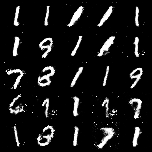

In [48]:
from IPython.display import Image

Image('92000.png')